# Ludność województw

Naszym celem jest napisanie prostego skryptu/programu w języku Python, który pobierze informacje na temat liczby ludności w województwach i powiazane dane GIS i je zwizualizuje.

Zacznijmy od wczytania wszystkich pakietów, które będziemy używać:


In [11]:
%matplotlib inline
import os
import re

import zipfile
import matplotlib.pyplot as plt
import geopandas  # depends on descartes
import pandas as pd
import seaborn as sns
import requests

Kolejny krokiem jest wczytania danych GIS. W tej części korzystałem z informacji i kodu zawartego w bardzo pomocnym [wpisie blogowym](https://www.mimuw.edu.pl/~walen/vis/wybory2018/).

In [12]:
gis_data_dir = '../gis_data'
def read_shape_from_zip(zip_filename):
    z = zipfile.ZipFile(zip_filename, mode="r")
    dbf_name = list(filter(
        lambda x: re.match(r'.*\.dbf$', os.path.basename(x)),
        z.namelist()
    ))[0]
    z.close()
    return geopandas.read_file(dbf_name, encoding='utf-8', vfs='zip://'+zip_filename)

fn_woj = f'{gis_data_dir}/wojewodztwa.zip'
woj = read_shape_from_zip(fn_woj)

Kolejny krok to znalezienie danych dotyczących liczby lundości w danych województwie. W tym celu trzeba wykonać odrobinę pracy detektywistycznej w bazach GUSu.

1. Zaczynamy od przeszukania zasobów [Banku Danych Lokalnych](https://bdl.stat.gov.pl/BDL/start).
2. Może tam odnaleźć między innymi kategorię "Ludność":

![GUS - lista kategorii](pics/gus_dane_bdl_ludnosc_1.png)

3. Kilkamy "Dalej", żeby dostać się do szczegółowych informacji.

![GUS - lista kategorii](pics/gus_dane_bdl_ludnosc_2.png)

Kluczowe dla nas są identyfikatory kategorii/grupy i podgrupy.

4. Wchodzimy na strony GUS dotyczące [API dla BDL](https://api.stat.gov.pl/Home/BdlApi).
5. Korzystając z wcześniej wynotowanych identifkatorów podgrupy pobieramy listę zmiennych dla wybranego tematu:

In [13]:
r = requests.get('http://bdl.stat.gov.pl/api/v1/variables?subject-id=P2914')
r.json()

{'totalRecords': 12,
 'page': 0,
 'pageSize': 10,
 'links': {'first': 'https://bdl.stat.gov.pl/api/v1/variables?subject-id=P2914&page=0&page-size=10',
  'self': 'https://bdl.stat.gov.pl/api/v1/variables?subject-id=P2914&page=0&page-size=10',
  'next': 'https://bdl.stat.gov.pl/api/v1/variables?subject-id=P2914&page=1&page-size=10',
  'last': 'https://bdl.stat.gov.pl/api/v1/variables?subject-id=P2914&page=1&page-size=10'},
 'results': [{'id': 199202,
   'subjectId': 'P2914',
   'n1': 'gminy bez miast na prawach powiatu',
   'n2': 'miejsce zamieszkania',
   'n3': 'stan na 30 czerwca',
   'n4': 'ogółem',
   'level': 6,
   'measureUnitId': 26,
   'measureUnitName': 'osoba'},
  {'id': 199194,
   'subjectId': 'P2914',
   'n1': 'gminy bez miast na prawach powiatu',
   'n2': 'miejsce zamieszkania',
   'n3': 'stan na 30 czerwca',
   'n4': 'mężczyźni',
   'level': 6,
   'measureUnitId': 26,
   'measureUnitName': 'osoba'},
  {'id': 199186,
   'subjectId': 'P2914',
   'n1': 'gminy bez miast na praw

Dostaliśmy szereg zmiennych. Teraz musimy wybrać te, które nas interesują. Bedą to:

```
{
  'id': 199207,
  'subjectId': 'P2914',
  'n1': 'miasta na prawach powiatu',
  'n2': 'miejsce zamieszkania',
  'n3': 'stan na 31 grudnia',
  'n4': 'ogółem',
  'level': 6,
  'measureUnitId': 26,
  'measureUnitName': 'osoba'
},
{
  'id': 199206,
  'subjectId': 'P2914',
  'n1': 'gminy bez miast na prawach powiatu',
  'n2': 'miejsce zamieszkania',
  'n3': 'stan na 31 grudnia',
  'n4': 'ogółem',
  'level': 6,
  'measureUnitId': 26,
  'measureUnitName': 'osoba'
}
```

Kolejny krokiem jest pobranie danych dla wybranch zmiennych na pozomie zagregowanym do poziomu województw. Odrobina poszukiwań w dokumentacji prowadzi nas do następujących zapytań, gdzie zmienną jest `id` z powyższych rekordów, a `unit-level=2` odpowiada za dane zagregowane na poziomie województw:

In [14]:
r1 = requests.get('https://bdl.stat.gov.pl/api/v1/data/by-variable/199207?year=2020&unit-level=2&page-size=20')
r2 = requests.get('https://bdl.stat.gov.pl/api/v1/data/by-variable/199206?year=2020&unit-level=2&page-size=20')

gminy_miasta_na_prawach_powiat = r1.json()
gminy_bez_miast_na_prawach_powiatu = r2.json()

Sprawdźmy rezultaty:

In [15]:
gminy_miasta_na_prawach_powiat['results'][:3]

[{'id': '011200000000',
  'name': 'MAŁOPOLSKIE',
  'values': [{'year': '2020', 'val': 971022, 'attrId': 1}]},
 {'id': '012400000000',
  'name': 'ŚLĄSKIE',
  'values': [{'year': '2020', 'val': 2498095, 'attrId': 1}]},
 {'id': '020800000000',
  'name': 'LUBUSKIE',
  'values': [{'year': '2020', 'val': 263481, 'attrId': 1}]}]

In [16]:
gminy_bez_miast_na_prawach_powiatu['results'][:3]

[{'id': '011200000000',
  'name': 'MAŁOPOLSKIE',
  'values': [{'year': '2020', 'val': 2439419, 'attrId': 1}]},
 {'id': '012400000000',
  'name': 'ŚLĄSKIE',
  'values': [{'year': '2020', 'val': 1994235, 'attrId': 1}]},
 {'id': '020800000000',
  'name': 'LUBUSKIE',
  'values': [{'year': '2020', 'val': 743664, 'attrId': 1}]}]

Porównajmy zawartość `id` z kodem terytorialnym będącym częścią danych GIS:

In [17]:
woj.head()

,JPT_SJR_KO,JPT_KOD_JE,JPT_NAZWA_,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,WAZNY_DO,JPT_KOD__1,...,JPT_KJ_I_1,JPT_KJ_I_2,JPT_OPIS,JPT_SPS_KO,ID_BUFOR_1,JPT_ID,JPT_KJ_I_3,Shape_Leng,Shape_Area,geometry
0,WOJ,24,śląskie,None,0,2017-10-10,None,2012-09-26,None,None,...,24,None,None,UZG,0,1331323,None,12.136952,1.557335,"MULTIPOLYGON (((494179.526 358814.295, 494173...."
1,WOJ,16,opolskie,None,0,2017-10-10,None,2012-09-26,None,None,...,16,None,None,UZG,0,1331326,None,9.005207,1.196205,"POLYGON ((417001.841 369554.248, 417005.901 36..."
2,WOJ,26,świętokrzyskie,None,0,2012-09-26,None,2012-09-26,None,None,...,26,None,None,UZG,0,829374,None,9.264959,1.491827,"POLYGON ((549668.108 320839.847, 549676.668 32..."
3,WOJ,22,pomorskie,None,0,2020-04-09,None,2012-09-26,None,None,...,22,None,None,UZG,0,1358902,None,13.167595,2.520630,"POLYGON ((414159.332 769636.478, 414269.395 76..."
4,WOJ,20,podlaskie,None,0,2019-03-21,None,2012-09-26,None,None,...,20,None,None,UZG,0,1353685,None,11.101166,2.718484,"POLYGON ((700075.252 572284.982, 700055.491 57..."


Skupmy się dla przykładu na danych dotyczących województwa śląskiego. Z danych BDL mamy:

```
{
    'id': '012400000000',
    'name': 'ŚLĄSKIE',
}
```

Z kolei widzimy, że w kolumnie `JPT_KOD_JE` dla województwa śląskiego mamy - `24`. Czyli, jeżeli zdecydujemy się wziąć podsłowo składające się z trzeciej i czwartej litery `id`, dostaniemy tą samą wartość. Szybki rzut oka pozwala zauważyć, że ta sama metoda działa dla pozostałych województw. Idealnym rozwiązaniem byłby dostęp do kodów bazy TERYT w BDL. Niestety musimy zadowolić się tym obejściem. Korzystając z poczynionych powyżej uwag, wczytajmy i przekształćmy dane z API BDL do `DataFrame`

In [18]:
dane_gminy_miasta = [
    {
        'JPT_KOD_JE': rec['id'][2:4],
        'Ludność gmin miast na prawach powiatu': rec['values'][0]['val']
    }
    for rec in gminy_miasta_na_prawach_powiat['results']
]

dane_gminy_bez_miast = [
    {
        'JPT_KOD_JE': rec['id'][2:4],
        'Ludność gmin bez miast na prawach powiatu': rec['values'][0]['val']
    }
    for rec in gminy_bez_miast_na_prawach_powiatu['results']
]

df_ludnosc = pd.merge(
    pd.DataFrame(dane_gminy_miasta),
    pd.DataFrame(dane_gminy_bez_miast),
    on='JPT_KOD_JE'
)

df_ludnosc['Ludność Ogółem'] = df_ludnosc['Ludność gmin miast na prawach powiatu'] +  df_ludnosc['Ludność gmin bez miast na prawach powiatu']
df_ludnosc.head()

,JPT_KOD_JE,Ludność gmin miast na prawach powiatu,Ludność gmin bez miast na prawach powiatu,Ludność Ogółem
0,12,971022,2439419,3410441
1,24,2498095,1994235,4492330
2,08,263481,743664,1007145
3,30,766547,2729903,3496450
4,32,545438,1142609,1688047


Połączmy teraz dane dotyczące ludności i dane GIS.

In [19]:
df_ludnosc_wojewodztwa = pd.merge(woj, df_ludnosc, on='JPT_KOD_JE')

I w końcu możemy przejść do wizualizacji danych:

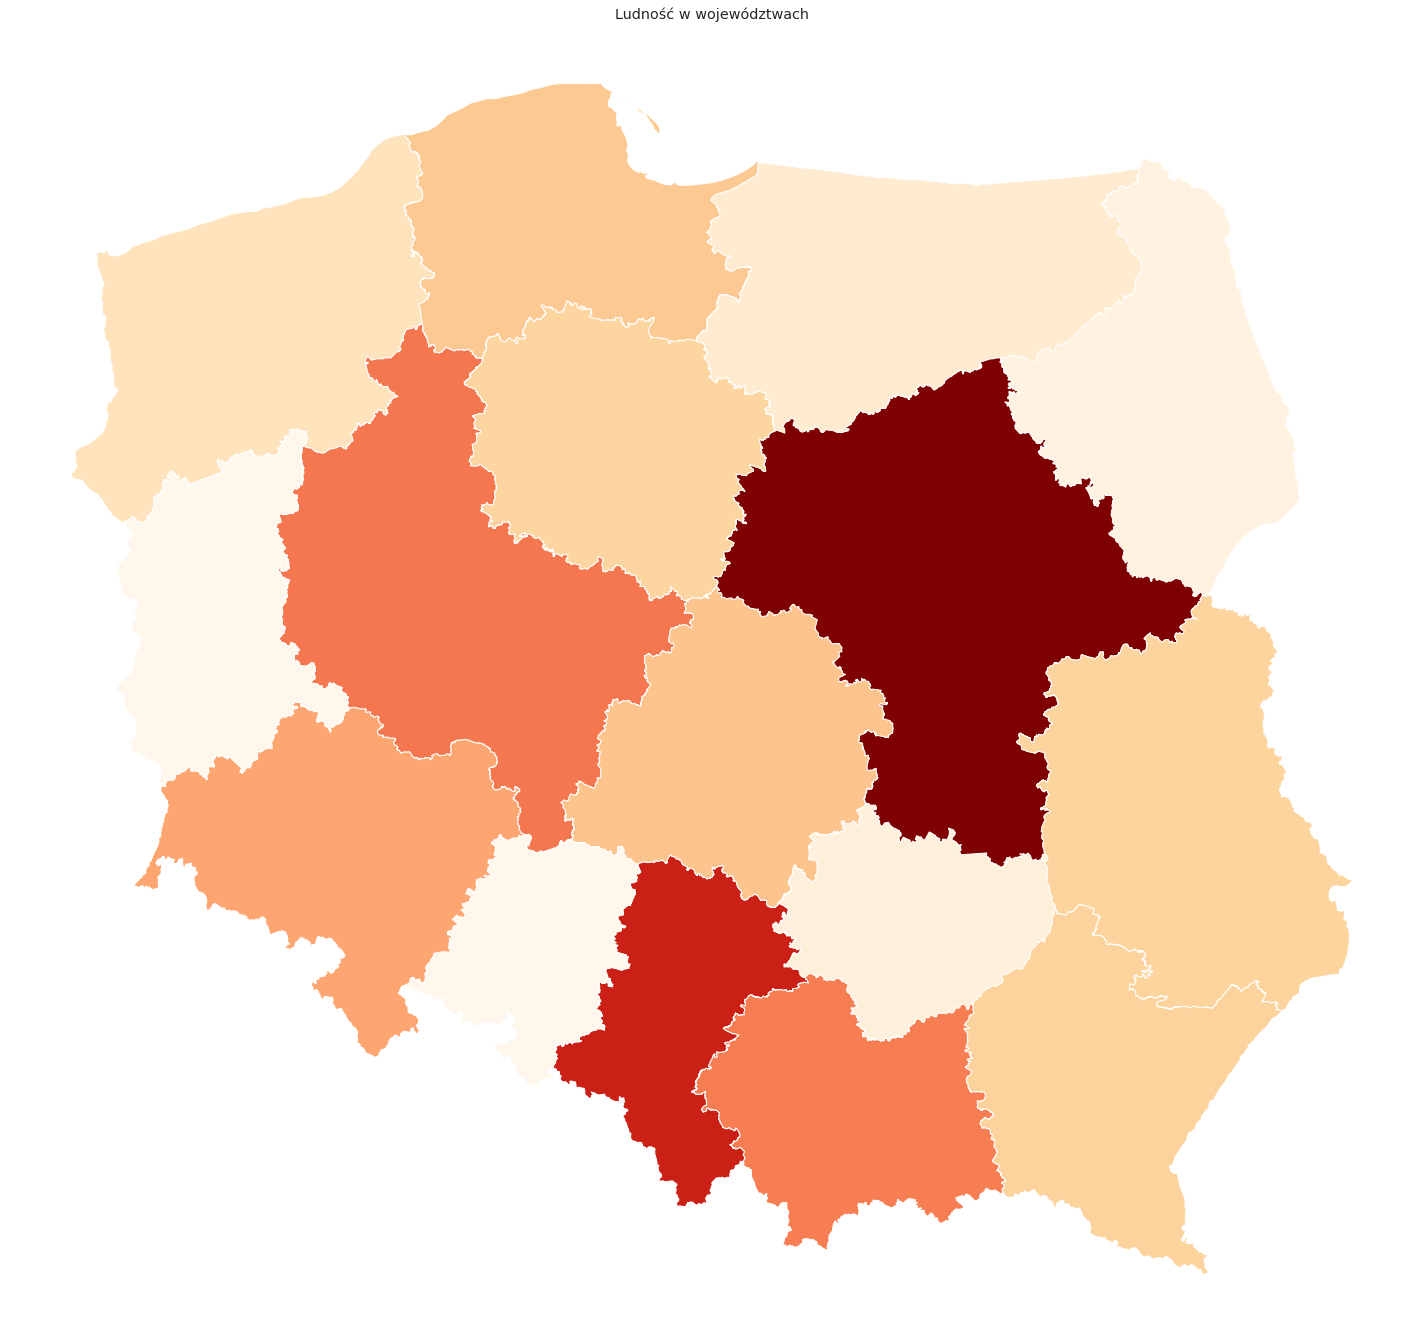

In [22]:
plt.rcParams['figure.figsize'] = (20, 20)
sns.set(style="white", font_scale=1.2)
ax = df_ludnosc_wojewodztwa.plot(
    column='Ludność Ogółem',
    cmap='OrRd',
)
ax.set_title("Ludność w województwach")
ax.grid(False)
ax.set_axis_off()
plt.tight_layout()
plt.show()